# Geometric Tensor Learning
---

In [1]:
import numpy as np
import numpy.ma as ma
from numpy.linalg import norm
import matplotlib.pyplot as plt
import networkx as nx

import project_path

from util.t2m import t2m
from util.m2t import m2t
from util.update_L_nograd import update_L
from util.update_L_nograd import fn_val as fnval_L
from util.update_X_nograd import update_X
from util.update_X_nograd import fn_val as fnval_X
from util.update_Sigma import update_Sigma
from util.update_Lambda_nograd import update_Lambda
from util.update_Sigma import fn_val as fnval_Sigma
from util.generate_data import generate_syn_data
from util.contaminate_data import contaminate_signal
from util.fn_vals import fn_val_L
from util.fn_vals import fn_val_G

In [2]:
sizes = (10,10,10,10)
ranks = (3,3,3,3)
n = len(sizes)

## Generate Graphs
In this part, we create Erdos-Renyi graphs for each mode.

In [3]:
G = [nx.erdos_renyi_graph(sizes[i], np.log(sizes[i])/sizes[i]) for i in range(n)] # List of graphs for each mode
Phi = [nx.laplacian_matrix(G[i]).todense() for i in range(n)]


In [4]:
def graph_filter(Lambda, filter_length=3):
    ''' Graph filter generating the graph stationary data.
    '''
    h = np.random.rand(filter_length)
    return sum(h[i]**i*Lambda**i for i in range(filter_length))

## Data Generation Methods

In this part, we try to generate data smooth and stationary on the product graph.

In [5]:
# # Generate data by sampling using covariances of each mode generated with graph filters H.
# covs = []
# X_smooth = np.zeros(sizes)
# for i in range(n):
#     W, V = np.linalg.eigh(Phi[i])
#     eigs = graph_filter(W)
#     H = V@np.diag(eigs)@V.transpose()
#     covs.append(H @ H)

#     col_inds = np.setdiff1d(np.arange(n), 1)
#     sz = np.array(sizes)
#     sz_cols = np.prod(sz[col_inds])
#     mean_temp = np.zeros(Phi[i].shape[0])
#     Xmat = np.random.multivariate_normal(mean_temp, covs[i], sz_cols).transpose()
#     X_smooth = X_smooth + m2t(Xmat, sizes, i)

In [6]:
## Generate data by multiplying the graph filter with white Gaussian noise.
# X_smooth = generate_syn_data(sizes, ranks)
# V_all = 1

# covs = []
# X_smooth = np.zeros(sizes)
# for i in range(n):
#     W, V = np.linalg.eigh(Phi[i])
#     if not(i):
#         W_all = W
#     else:
#         W_all = np.kron(np.ones(W.size), W_all) + np.kron(W,np.ones(W_all.size).flatten('F'))
#     V_all = np.kron(V_all, V)

# X_stat = np.tensordot(H, np.random.randn(H.shape[1]), axes=([1],[0])).reshape(sizes)
# del W_all, V_all, H, eigs


In [7]:
## Generate data by multiplying the eigenvectors of the Graph Laplacian
# with i.i.d. Gaussian noise with variance given by the eigenvalues of the Laplacian.

V = []
for i in range(n):
    w, temp_v = np.linalg.eig(Phi[i])
    ind = np.argsort(abs(w))
    print(w[ind])
    V.append(temp_v[:,ind])
    if not(i):
        W_all = w[ind]
    else:
        W_all = np.kron(np.ones(w.size), W_all) + np.kron(w[ind],np.ones(W_all.size).flatten('F'))

C = np.random.randn(np.prod(sizes))
C[W_all<1e-8] = 0
C[W_all>1e-8] = C[W_all>1e-8] / W_all[W_all>1e-8]
C = C.reshape(sizes)

# C = W_all.reshape(sizes)**-1
X_smooth = C.copy()
for i in range(n):
    X_smooth = m2t(V[i]*t2m(X_smooth,i), sizes, i)

[0.00000000e+00 0.00000000e+00 1.31249687e-16 5.85786438e-01
 1.06814835e+00 2.00000000e+00 2.48236191e+00 3.41421356e+00
 3.51763809e+00 4.93185165e+00]
[ 0.00000000e+00 -6.49273416e-17  4.25261212e-01  7.62395720e-01
  1.00000000e+00  1.46494510e+00  2.59988610e+00  3.57653843e+00
  3.89879885e+00  6.27217460e+00]
[0.         0.         0.         1.43844719 1.71175439 3.
 3.12596795 4.87403205 5.56155281 6.28824561]
[1.69472632e-16 2.82907309e-01 6.26190015e-01 1.00000000e+00
 1.00000000e+00 1.64679986e+00 2.31371322e+00 2.75466473e+00
 5.03518655e+00 5.34053832e+00]


Let's see how smooth the data is compared to a random signal with similar Frobenius norm.

In [8]:
random_signal = np.random.randn(X_smooth.size).reshape(sizes)
random_signal = random_signal * norm(X_smooth)/norm(random_signal)
for i in range(n):
    x_smooth_val = np.trace(t2m(X_smooth,i).transpose()@Phi[i]@t2m(X_smooth,i))
    rand_smooth_val = np.trace(t2m(random_signal,i).transpose()@Phi[i]@t2m(random_signal,i))
    print('At mode {:.0f} the smoothness for X is: {:.2e}, while for a random signal with same frobenius norm it is: {:.2e} '.format(i,x_smooth_val, rand_smooth_val))
    

At mode 0 the smoothness for X is: 3.91e+02, while for a random signal with same frobenius norm it is: 1.39e+03 
At mode 1 the smoothness for X is: 3.65e+02, while for a random signal with same frobenius norm it is: 1.58e+03 
At mode 2 the smoothness for X is: 5.72e+02, while for a random signal with same frobenius norm it is: 2.04e+03 
At mode 3 the smoothness for X is: 5.70e+02, while for a random signal with same frobenius norm it is: 1.56e+03 


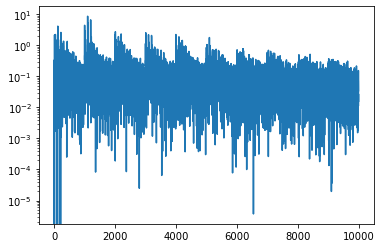

In [9]:
plt.semilogy(abs(C.ravel()))

Let's see how stationarity looks like.

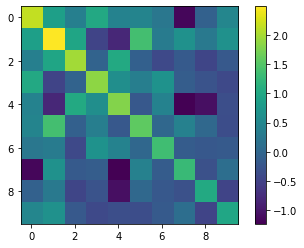

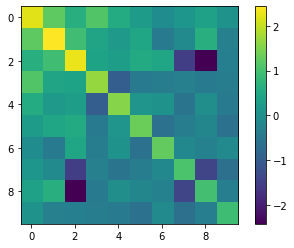

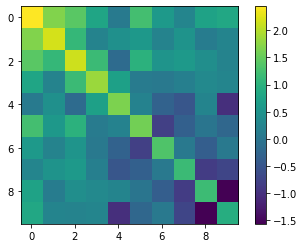

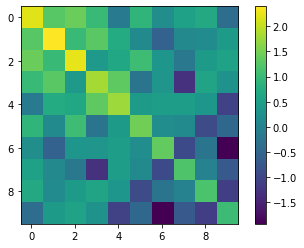

In [10]:
for i in range(n):
    P_X = V[i].transpose()@t2m(X_smooth,i)
    psd = P_X@P_X.transpose()
    plt.imshow(np.log10(abs(psd)))
    plt.colorbar()
    plt.show()

Cartesian graph eigenvalues.

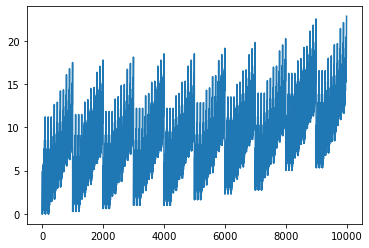

In [11]:
plt.plot(W_all)
plt.show()

## The Algorithm

In below, we add noise to data and run our algorithm to recover the original signal back.

In [32]:
def initialize_nograd(n, sizes):
    # Parameters
    alpha = [[10**-1 for i in range(n)], 
        [10**-1 for i in range(n)], 
        [10**-1 for i in range(n)], 
        [10**-4 for i in range(n)]]
    theta = [10**-5 for i in range(n)]
    gamma = [10**-0.2 for i in range(n)]

    # Initializations
    L = np.zeros(sizes)
    G_var = [np.zeros(sizes) for i in range(n)]
    X = [np.zeros(sizes) for i in range(n)]
    Lx = [np.zeros(sizes) for i in range(n)]
    Sigma = []
    for i in range(n):
        temp = np.random.standard_normal(sizes[i]**2).reshape([sizes[i], sizes[i]])
        Sigma.append(temp@temp.transpose())

    Lambda = [[np.zeros(sizes) for i in range(n)],
        [np.zeros(sizes) for i in range(n)],
        [np.zeros(sizes) for i in range(n)],
        [np.zeros([sizes[i],sizes[i]]) for i in range(n)]]
    
    return L, G_var, Lx, X, Sigma, Lambda, alpha, theta, gamma

In [33]:
L, G_var, Lx, X, Sigma, Lambda, alpha, theta, gamma = initialize_nograd(n, sizes)

In [51]:
# Contaminate data.
Y = contaminate_signal(X_smooth, target_SNR=0)

In [52]:
for i in range(n):
    x_smooth_val = np.trace(t2m(Y.data,i).transpose()@Phi[i]@t2m(Y.data,i))
    l_smooth_val = np.trace(t2m(X_smooth,i).transpose()@Phi[i]@t2m(X_smooth,i))
    print('Ratio is (Y/X): {:.6f}'.format(x_smooth_val/l_smooth_val))

Ratio is (Y/X): 4.688898
Ratio is (Y/X): 5.360561
Ratio is (Y/X): 4.531264
Ratio is (Y/X): 3.749720


In [53]:
# Function value for original X
X_rep = [X_smooth for i in range(n)]
err_orig = fn_val_L(X_smooth, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_orig = fn_val_G(X_rep, X_smooth, Phi, Lambda[0], alpha[0], gamma)[1]
x_sigma = [t2m(X_smooth,i)@t2m(X_smooth,i).transpose() for i in range(n)]
comm_orig = fnval_Sigma(x_sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[1]

print('Error value of original signal: {:.1e}'.format(err_orig))
print('Smoothness value of original signal: {:.1e}'.format(sum(smooth_orig)))
print('Commutivity value of original signal: {:.1e}'.format(sum(comm_orig)))

Error value of original signal: 7.9e+02
Smoothness value of original signal: 1.2e+03
Commutivity value of original signal: 3.2e-01


In [54]:
G_inv = [np.linalg.inv(gamma[i]*Phi[i] + alpha[0][i]*np.identity(sizes[i])) for i in range(n)]
max_iter = 500
err_tol = 1e-3
iter = 0
fval_tot = []
lam_val = []
# ADMM Loop
while True:
    # L Update
    prev_val = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])[0]
    temp = np.zeros(sizes)
    for i in range(n):
        temp += alpha[0][i]*(G_var[i] + Lambda[0][i])
        temp += alpha[1][i]*(Lx[i] + Lambda[1][i])
    L = temp/(1+sum(alpha[0]) + sum(alpha[1]))
    L[~Y.mask] = L[~Y.mask] + Y[~Y.mask]/(sum(alpha[0]) + sum(alpha[1]) + 1)
    fval_data = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])
    fval_data_change = fval_data[0]-prev_val
    
    # G Update
    prev_val = fn_val_G(G_var, L, Phi, Lambda[0], alpha[0], gamma)[0]
    G_var = [m2t(alpha[0][i]*G_inv[i]*t2m(L-Lambda[0][i], i), sizes, i) for i in range(n)]
    fval_G = fn_val_G(G_var, L, Phi, Lambda[0], alpha[0], gamma)
    fval_G_change = fval_G[0] - prev_val

    # Lx Update
    prev_val = fnval_L(Lx, L, X, Lambda[1:], Sigma, alpha[1:])[0]
    Lx, fval_L, fval_low, _, _ = update_L(Lx, L, X, Lambda[1:], Sigma, alpha[1:], track_fval=True)
    fval_L_change = fval_L - prev_val

    # X Update
    prev_val = sum(fnval_X(X,Lx,Lambda[2:],Sigma,alpha[2:])[1])
    X, _, fval_X, _ = update_X(X, Lx, Lambda[2:], Sigma, alpha[2:], track_fval=True)
    fval_X_change = sum(fval_X) - prev_val

    # Sigma Update 
    prev_val = fnval_Sigma(Sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[0]
    Sigma, fval_Sigma, _, _ = update_Sigma(Sigma, Lx, X, Phi, Lambda[3], alpha[3], theta, track_fval=True)
    fval_Sigma_change = fval_Sigma - prev_val
    
    fval_tot.append(fval_data[1] + fval_G[0] + sum(fval_low) + sum(fval_X) + fval_Sigma)
    print('Objective function changes for L: {:.2e}, G: {:.2e}, Lx: {:.2e}, X: {:.2e}, Sigma: {:.2e}'.format(
        fval_data_change,
        fval_G_change,
        fval_L_change,
        fval_X_change,
        fval_Sigma_change
    ))
    print('Total Objective Function Value at iter {}: {:.3e}'.format(iter, fval_tot[-1]))
    # Dual Update
    Lambda, _, norm_lambda = update_Lambda(Lambda,L,Lx,X,G_var,Sigma)
    lam_val.append(norm_lambda)
    if iter==max_iter:
        break
    if norm_lambda<=err_tol:
        break
    iter += 1

Objective function changes for L: -9.79e+02, G: -6.48e+01, Lx: -1.09e+02, X: -5.42e+01, Sigma: -8.67e-02
Total Objective Function Value at iter 0: 4.097e+03
Objective function changes for L: -1.50e+01, G: -9.00e+00, Lx: -9.03e+01, X: -4.54e+01, Sigma: -2.45e+00
Total Objective Function Value at iter 1: 3.697e+03
Objective function changes for L: -8.80e-01, G: -6.63e+00, Lx: -1.66e+01, X: -1.13e+01, Sigma: -1.26e+00
Total Objective Function Value at iter 2: 3.460e+03
Objective function changes for L: -1.31e+00, G: -5.08e+00, Lx: -1.18e+00, X: -6.98e-01, Sigma: -6.33e-02
Total Objective Function Value at iter 3: 3.395e+03
Objective function changes for L: -2.98e+00, G: -3.49e+00, Lx: -7.82e+00, X: -4.72e+00, Sigma: -4.99e-01
Total Objective Function Value at iter 4: 3.449e+03
Objective function changes for L: -6.31e+00, G: -2.27e+00, Lx: -1.36e+01, X: -8.01e+00, Sigma: -6.88e-01
Total Objective Function Value at iter 5: 3.563e+03
Objective function changes for L: -8.84e+00, G: -1.49e+00,

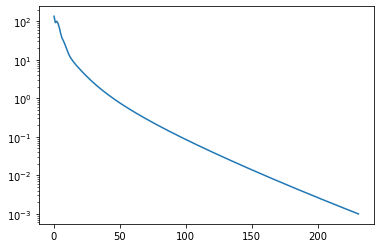

In [55]:
plt.semilogy(lam_val)

## Examine Results
Let's see how our algorithm performed. Starting with normalized error from the original signal.

In [56]:
print('Normalized error of the output: {:.2f}'.format(norm(X_smooth-L)/norm(X_smooth)))
print('Normalized error of the input: {:.2f}'.format(norm(X_smooth-Y)/norm(X_smooth)))


Normalized error of the output: 0.57
Normalized error of the input: 1.01


In [57]:
for i in range(n):
    x_smooth_val = np.trace(t2m(X_smooth,i).transpose()@Phi[i]@t2m(X_smooth,i))
    l_smooth_val = np.trace(t2m(L,i).transpose()@Phi[i]@t2m(L,i))
    print('The smoothness value for X is: {:.2f}, while for L it is: {:.2f}'.format(
        x_smooth_val,
        l_smooth_val
        )
    )
    print('Ratio is (X/L): {:.6f}'.format(x_smooth_val/l_smooth_val))

The smoothness value for X is: 390.79, while for L it is: 78.81
Ratio is (X/L): 4.958740
The smoothness value for X is: 365.17, while for L it is: 88.40
Ratio is (X/L): 4.130990
The smoothness value for X is: 572.03, while for L it is: 83.63
Ratio is (X/L): 6.839652
The smoothness value for X is: 569.82, while for L it is: 150.12
Ratio is (X/L): 3.795776


In [58]:
for i in range(n):
    x_smooth_val = np.trace(t2m(Y.data,i).transpose()@Phi[i]@t2m(Y.data,i))
    l_smooth_val = np.trace(t2m(L,i).transpose()@Phi[i]@t2m(L,i))
    print('The smoothness value for Y is: {:.4e}, while for L it is: {:.4e}'.format(
        x_smooth_val,
        l_smooth_val
        )
    )
    print('Ratio is (Y/L): {:.6f}'.format(x_smooth_val/l_smooth_val))

The smoothness value for Y is: 1.8324e+03, while for L it is: 7.8809e+01
Ratio is (Y/L): 23.251023
The smoothness value for Y is: 1.9575e+03, while for L it is: 8.8398e+01
Ratio is (Y/L): 22.144421
The smoothness value for Y is: 2.5920e+03, while for L it is: 8.3634e+01
Ratio is (Y/L): 30.992271
The smoothness value for Y is: 2.1367e+03, while for L it is: 1.5012e+02
Ratio is (Y/L): 14.233097


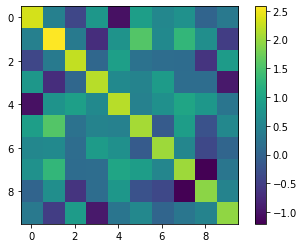

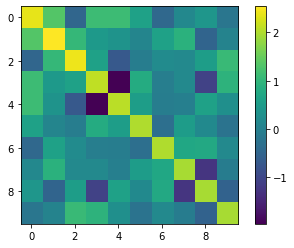

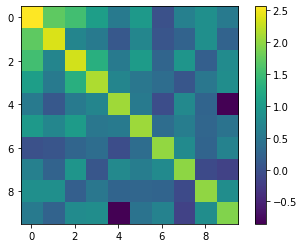

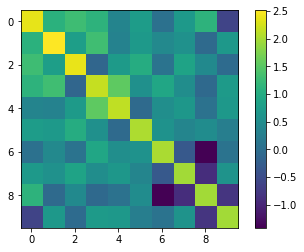

In [59]:
# Plot stationarity for Y
for i in range(n):
    P_Y = V[i].transpose()@t2m(Y.data,i)
    cov = P_Y@P_Y.transpose()
    plt.imshow(np.log10(abs(cov)))
    plt.colorbar()
    plt.show()

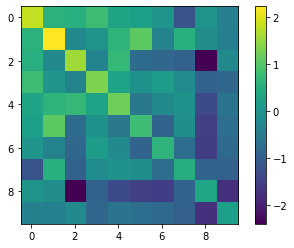

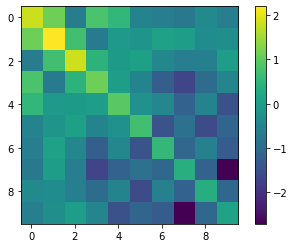

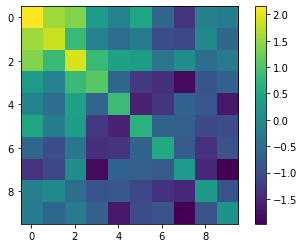

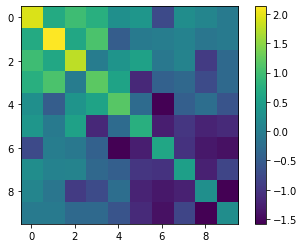

In [60]:
# Plot stationarity for L
for i in range(n):
    P_L = V[i].transpose()@t2m(L,i)
    cov = P_L@P_L.transpose()
    plt.imshow(np.log10(abs(cov)))
    plt.colorbar()
    plt.show()

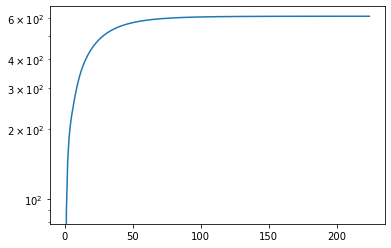

In [61]:
plt.semilogy(fval_tot[7:]-min(fval_tot[7:]))
plt.show()

In [62]:
# Function value for original X
X_rep = [X_smooth for i in range(n)]
err_orig = fn_val_L(X_smooth, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_orig = fn_val_G(X_rep, X_smooth, Phi, Lambda[0], alpha[0], gamma)[1]
x_sigma = [t2m(X_smooth,i)@t2m(X_smooth,i).transpose() for i in range(n)]
comm_orig = fnval_Sigma(x_sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[1]

orig_fn_val = sum(err_orig + smooth_orig + comm_orig)
print('Function value of original signal: {:.1e}'.format(orig_fn_val))

Function value of original signal: 4.4e+03


In [63]:
# Function value for learned L
L_rep = [L for i in range(n)]
err_l = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_l = fn_val_G(L_rep, L, Phi, Lambda[0], alpha[0], gamma)[1]
l_sigma = [t2m(L,i)@t2m(L,i).transpose() for i in range(n)]
comm_l = fnval_Sigma(l_sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[1]

l_fn_val = sum(err_l + smooth_l + comm_l)
print('Function value of the output signal: {:.1e}'.format(l_fn_val))

Function value of the output signal: 3.2e+03


In [64]:
print(err_orig)
print(err_l)

791.2816597987998
730.0019030840446


In [65]:
print(sum(smooth_orig))
print(sum(smooth_l))

1197.4348162898873
252.98806380581124


In [66]:
print(sum(comm_orig))
print(sum(comm_l))

0.32061170465524963
0.032241697285923375


In [67]:
# Ymat = t2m(Y.data, 0)
# cov = Ymat@Ymat.transpose()

# fig, ax = plt.subplots(figsize = (15,15))
# im = ax.imshow(cov)

# for i in range(cov.shape[0]):
#     for j in range(cov.shape[1]):
#         text = ax.text(j, i, np.round(np.log10(cov[i, j]), 2) ,
#                        ha="center", va="center", color="w")